# Loading Dataset

In [295]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
import folium
from folium.plugins import MarkerCluster
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from prettytable import PrettyTable 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [180]:
data = pd.read_csv("trip_data_1.csv")
data2 = pd.read_csv("trip_fare_1.csv")
data.columns = [x.strip().replace(' ', '') for x in data.columns] ## Removing white spaces from the column names
data2.columns = [x.strip().replace(' ', '') for x in data2.columns]
data.shape

(14776615, 14)

In [329]:
data2.shape

(14776615, 11)

In [182]:
data_merged = pd.merge(data, data2, on=["medallion",'hack_license','vendor_id','pickup_datetime'])
data_merged.columns = [x.strip().replace(' ', '') for x in data_merged.columns]
data_merged.head(5)

medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

   ...  pickup_latitude  dropoff_longitude  dropoff_latitude  payment_type  \
0  ...        40.757977         -73.989838         40.751171           CSH   
1  ...        40.731781         -73.994499         40.750660           CSH   
2  ...        40.737770         -74.009834         40.726002           CSH   
3  ...        40.759945         -73.984734         40.759388           CSH   
4  ...        40.748528         -74.002586         40.747868           CSH   

  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0         6.5        0.0      0.5         0.0           0.0           7.0  
1         6.0        0.5      0.5         0.0           0.0           7.0  
2         5.5        1.0      0.5         0.0           0.0           7.0  
3         5.0        0.5      0.5         0.0           0.0           6.0  
4         9.5        0.5      0.5         0.0           0.0          10.5  

[5 rows x 21 columns]

# Data Screening

In [183]:
# Shape of the merged dataset
print("No. of Row: ",data_merged.shape[0])
print('No. of features: ', data_merged.shape[1])

No. of Row:  14776615
No. of features:  21


In [184]:
data_merged.dtypes

medallion              object
hack_license           object
vendor_id              object
rate_code               int64
store_and_fwd_flag     object
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
trip_time_in_secs       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
payment_type           object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtype: object

In [185]:
data_merged.describe()

rate_code  passenger_count  trip_time_in_secs  trip_distance  \
count  1.477662e+07     1.477662e+07       1.477662e+07   1.477662e+07   
mean   1.034273e+00     1.697372e+00       6.834236e+02   2.770976e+00   
std    3.387715e-01     1.365396e+00       4.944063e+02   3.305923e+00   
min    0.000000e+00     0.000000e+00       0.000000e+00   0.000000e+00   
25%    1.000000e+00     1.000000e+00       3.600000e+02   1.000000e+00   
50%    1.000000e+00     1.000000e+00       5.540000e+02   1.700000e+00   
75%    1.000000e+00     2.000000e+00       8.850000e+02   3.060000e+00   
max    2.100000e+02     2.550000e+02       1.080000e+04   1.000000e+02   

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      1.477662e+07     1.477662e+07       1.477653e+07      1.477653e+07   
mean      -7.263634e+01     4.001440e+01      -7.259443e+01      3.999219e+01   
std        1.013819e+01     7.789904e+00       1.028860e+01      7.537067e+00   
min       -2.771285e+03    -3.547921e+03      -2.350956e+03     -3.547921e+03   
25%       -7.399188e+01     4.073551e+01      -7.399121e+01      4.073468e+01   
50%       -7.398166e+01     4.075315e+01      -7.398013e+01      4.075362e+01   
75%       -7.396684e+01     4.076729e+01      -7.396390e+01      4.076819e+01   
max        1.124042e+02     3.310365e+03       2.228738e+03      3.477106e+03   

        fare_amount     surcharge       mta_tax    tip_amount  tolls_amount  \
count  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07   
mean   1.166472e+01  3.204904e-01  4.983970e-01  1.267509e+00  2.018670e-01   
std    9.639219e+00  3.675741e-01  2.826541e-02  2.046084e+00  1.035481e+00   
min    2.500000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    6.500000e+00  0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00   
50%    9.000000e+00  0.000000e+00  5.000000e-01  8.000000e-01  0.000000e+00   
75%    1.300000e+01  5.000000e-01  5.000000e-01  2.000000e+00  0.000000e+00   
max    5.000000e+02  1.250000e+01  5.000000e-01  2.000000e+02  2.000000e+01   

       total_amount  
count  1.477662e+07  
mean   1.395298e+01  
std    1.146469e+01  
min    2.500000e+00  
25%    7.700000e+00  
50%    1.050000e+01  
75%    1.550000e+01  
max    6.500000e+02

In [186]:
## Checking null values
data_merged.isnull().sum()

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326207
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          86
dropoff_latitude           86
payment_type                0
fare_amount                 0
surcharge                   0
mta_tax                     0
tip_amount                  0
tolls_amount                0
total_amount                0
dtype: int64

# Data Preprocessing and Exploratory Analysis

According to the Data Dictionary, rate codes are: 
1. Standard rate
2. JFK
3. Newark
4. Nassau or Westchester
5. Negotiated fare
6. Group ride

In [187]:
data_merged.rate_code.unique()

array([  1,   2,   4,   5,   3,   6,   8,   0, 210,  28,   7,   9,  65,
       128])

In [188]:
# Removing rows with unwanted rate codes from the data
data_merged = data_merged.drop(data_merged[(data_merged['rate_code'] == 210) | (data_merged['rate_code'] == 0) | # Removal of outliers in the rate code
                       (data_merged['rate_code'] == 28) | (data_merged['rate_code'] == 7) |
                        (data_merged['rate_code'] == 9) | (data_merged['rate_code'] == 65)|
                         (data_merged['rate_code'] == 128)| (data_merged['rate_code'] == 8)].index)

In [189]:
data_merged.passenger_count.unique()

array([  4,   1,   2,   3,   5,   6,   0, 208,   9, 255])

According to the New York Taxi law, Taxi's have a maximum capacity of 6 people

In [190]:
# Removing passenger values greater than 6 and the value 0
data_merged = data_merged.drop(data_merged[(data_merged['passenger_count'] == 0)
                                           |(data_merged['passenger_count']== 9)
                                           |(data_merged['passenger_count'] == 208)
                                           |(data_merged['passenger_count'] == 255)].index)

In [191]:
# Droping null values
data_merged = data_merged.dropna()
# Droping column store_and_fwd_flag as it has a large number of null values
data_merged = data_merged.drop('store_and_fwd_flag',axis =1)

In [192]:
# Droping trips with zero distance
data_merged = data_merged.drop(data_merged[data_merged['trip_distance'] == 0].index)
# Droping trips with trip time zero
data_merged = data_merged.drop(data_merged[(data_merged['trip_time_in_secs'] == 0)].index)

In [193]:
# Calculating average taxi speed (speed=distance/time)
data_merged['avg_speed'] = data_merged['trip_distance']/data_merged['trip_time_in_secs']

Text(0.5, 1.0, 'Correlation Plot')

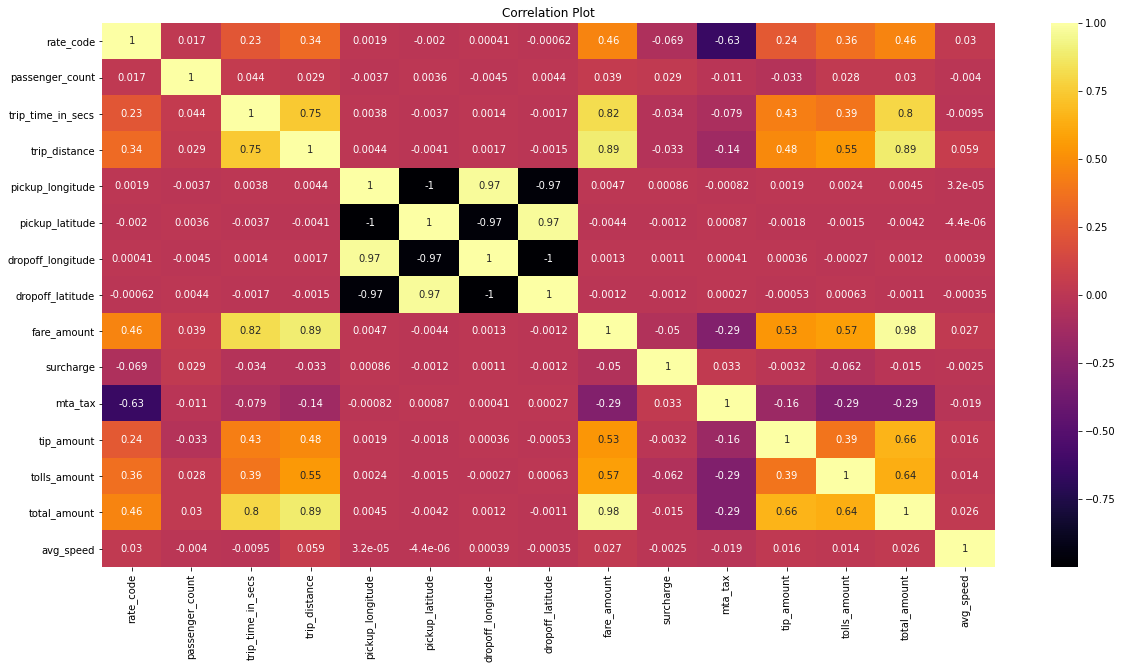

In [194]:
# Correlation Matrix
plt.figure(figsize=(20,10))
sns.heatmap(data_merged.corr(), annot=True, cmap='inferno')
plt.title('Correlation Plot')

Some notable correlations:
- trip distance and trip duration(trip_time_in_sec) have high positive correlation.
- rate code and mta_tax has high negative correlation
- trip duration(trip_time_in_sec) and fare_amount have high positive correlation
- trip duration(trip_time_in_sec and total amount have high positive correlation
- trip distance, fair amount and total amount have high correlation
- total amount and tip amount have positive correlation.

## What are busiest locations and hours?

### Busiest Location

In [195]:
# Rounding of coordinates
data_merged[['dropoff_longitude','dropoff_latitude','pickup_longitude','pickup_latitude']] = data_merged[['dropoff_longitude','dropoff_latitude','pickup_longitude','pickup_latitude']].round(2)

In [196]:
# Derivation of geocodes from 
data_merged['pickup_geocode'] = data_merged.pickup_latitude.astype(str) + ', ' + data_merged.pickup_longitude.astype(str)
data_merged['dropoff_geocode'] = data_merged.dropoff_latitude.astype(str) + ', ' + data_merged.dropoff_longitude.astype(str)
data_merged.tail(5)

medallion                      hack_license  \
14776610  B33E71CD9E8FE1BE3B70FEB6E807DD15  BAF57796E45D921BB23217E17A372FF6   
14776611  ED160B76D5349C8AC1ECF22CD4B8D538  3B93F6DA5DEBDE9560993FA624C4FF76   
14776612  D83F9AC0E33F6F19869C243BE6AB6FE5  85A55B6772275374EF90AC9457DC1F83   
14776613  04E59442A7DDBCE515E33CD355D866E7  7913172189931A1A1632562B10AB53C4   
14776614  D30BED60331C79E3F7ACD05B325ED42F  B5E1D2461A5BCC8819188DACEC17CD69   

         vendor_id  rate_code      pickup_datetime     dropoff_datetime  \
14776610       CMT          1  2013-01-06 04:58:23  2013-01-06 05:11:24   
14776611       CMT          1  2013-01-08 14:42:04  2013-01-08 14:50:27   
14776612       CMT          1  2013-01-10 13:29:23  2013-01-10 13:34:45   
14776613       CMT          1  2013-01-06 16:30:15  2013-01-06 16:42:26   
14776614       CMT          1  2013-01-05 20:38:46  2013-01-05 20:43:06   

          passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
14776610                1                781            3.3            -73.99   
14776611                1                503            1.0            -73.99   
14776612                1                321            0.9            -73.98   
14776613                1                730            1.3            -73.97   
14776614                1                260            0.8            -73.98   

          ...  payment_type  fare_amount  surcharge mta_tax  tip_amount  \
14776610  ...           CSH         13.0        0.5     0.5         0.0   
14776611  ...           CSH          7.5        0.0     0.5         0.0   
14776612  ...           CSH          6.0        0.0     0.5         0.0   
14776613  ...           CSH          9.5        0.0     0.5         0.0   
14776614  ...           CSH          5.0        0.5     0.5         0.0   

          tolls_amount  total_amount  avg_speed  pickup_geocode  \
14776610           0.0          14.0   0.004225   40.76, -73.99   
14776611           0.0           8.0   0.001988   40.73, -73.99   
14776612           0.0           6.5   0.002804   40.79, -73.98   
14776613           0.0          10.0   0.001781   40.76, -73.97   
14776614           0.0           6.0   0.003077   40.77, -73.98   

          dropoff_geocode  
14776610    40.77, -73.95  
14776611    40.72, -73.98  
14776612    40.79, -73.97  
14776613    40.77, -73.99  
14776614    40.77, -73.99  

[5 rows x 23 columns]

In [197]:
# Top 5 busiest pickup locations
pickup = data_merged.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(5)
pickup = pickup.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()
pickup_data = pickup.copy()
pickup_data = pickup_data.rename(columns={'pickup_geocode':'Pickup_Geocode'})
pickup_data['location'] = pickup_data.Pickup_Geocode.apply(geolocator.reverse)
pickup_data['address'] = [i.address for i in pickup_data.location]
pickup_data['address'] = pickup_data['address'].astype(str)
pickup_data['zipcode'] = pickup_data['address'].str.extract('(\d{5})', expand=True).astype(int)
pickup_data.drop('location',axis=1,inplace=True)
pickup_data

Pickup_Geocode  Number of Trips  \
0  40.76, -73.97           457981   
1  40.75, -73.99           424469   
2  40.76, -73.98           388643   
3  40.75, -73.98           370437   
4  40.74, -73.99           341385   

                                             address  zipcode  
0  664, Lexington Avenue, Manhattan Community Boa...    10022  
1  137, West 33rd Street, Manhattan Community Boa...    10001  
2  1270 Avenue of the Americas, 1270, 6th Avenue,...    10020  
3  35, East 38th Street, Murray Hill, Manhattan C...    10016  
4  10, East 21st Street, Manhattan Community Boar...    10010

In [198]:
# Top 5 busiest Dropoff Locations
dropoff = data_merged.groupby('dropoff_geocode')['dropoff_geocode'].count().sort_values(ascending=False).head(5)
dropoff = dropoff.to_frame().rename(columns={'dropoff_geocode':'Number of Trips'}).reset_index()
dropoff_data = dropoff.copy()
dropoff_data = dropoff_data.rename(columns={'dropoff_geocode':'Dropoff_Geocode'})
dropoff_data['location'] = dropoff_data.Dropoff_Geocode.apply(geolocator.reverse)
dropoff_data['address'] = [i.address for i in dropoff_data.location]
dropoff_data['address'] = dropoff_data['address'].astype(str)
dropoff_data['zipcode'] = dropoff_data['address'].str.extract('(\d{5})', expand=True).astype(int)
dropoff_data.drop('location',axis=1,inplace=True)
dropoff_data

Dropoff_Geocode  Number of Trips  \
0   40.76, -73.97           417163   
1   40.76, -73.98           412274   
2   40.75, -73.99           381968   
3   40.75, -73.98           366562   
4   40.74, -73.99           296985   

                                             address  zipcode  
0  664, Lexington Avenue, Manhattan Community Boa...    10022  
1  1270 Avenue of the Americas, 1270, 6th Avenue,...    10020  
2  137, West 33rd Street, Manhattan Community Boa...    10001  
3  35, East 38th Street, Murray Hill, Manhattan C...    10016  
4  10, East 21st Street, Manhattan Community Boar...    10010

In [199]:
data_merged2 = pd.merge(pickup_data, dropoff_data, on=["address",'zipcode'])

In [200]:
data_merged2['Number_of_trips'] = data_merged2['Number of Trips_x']+data_merged2['Number of Trips_x']
data_merged2.rename(columns={'Dropoff_Geocode':'Geocode'},inplace=True)
data_merged2.drop(['Number of Trips_x','Number of Trips_y','Pickup_Geocode'],axis=1,inplace = True)
data_merged2.head()

address  zipcode        Geocode  \
0  664, Lexington Avenue, Manhattan Community Boa...    10022  40.76, -73.97   
1  137, West 33rd Street, Manhattan Community Boa...    10001  40.75, -73.99   
2  1270 Avenue of the Americas, 1270, 6th Avenue,...    10020  40.76, -73.98   
3  35, East 38th Street, Murray Hill, Manhattan C...    10016  40.75, -73.98   
4  10, East 21st Street, Manhattan Community Boar...    10010  40.74, -73.99   

   Number_of_trips  
0           915962  
1           848938  
2           777286  
3           740874  
4           682770

### Visual (Busiest Location)

In [291]:
# Map Creation
m = folium.Map(location=data_merged[["dropoff_latitude", "dropoff_longitude"]].mean().to_list(), zoom_start=2)

for i in range(0,dropoff_data.shape[0]): # .shape[0] for Pandas DataFrame is the number of rows
    # create marker for location i 
    markerObj = folium.Marker(location = data_merged2['Geocode'][i].split(','),popup = data_merged2["address"][i])
    # add marker to map
    markerObj.add_to(m)
# display map
m

**All the busy locations for pickup and drop off are in Manhattan and 664, Lexington Avenue, Manhattan Community Board 5, Manhattan, New York, 10022 is the busiest spot for pickup and dropoff**

In [202]:
# Convering features from object to datetime object
data_merged['pickup_datetime']=pd.to_datetime(data_merged['pickup_datetime'])
data_merged['dropoff_datetime']=pd.to_datetime(data_merged['dropoff_datetime'])

In [203]:
# creating new features representing name of the day for rides
data_merged['pickup_day']=data_merged['pickup_datetime'].dt.day_name()
data_merged['dropoff_day']=data_merged['dropoff_datetime'].dt.day_name()

In [204]:
# creating new features with name of the day represented as integers
data_merged['pickup_day_no']=data_merged['pickup_datetime'].dt.weekday
data_merged['dropoff_day_no']=data_merged['dropoff_datetime'].dt.weekday

In [205]:
# Features represent deop off and pickup time in hourly manner
data_merged['pickup_hour']=data_merged['pickup_datetime'].dt.hour
data_merged['dropoff_hour']=data_merged['dropoff_datetime'].dt.hour

### Busiest day

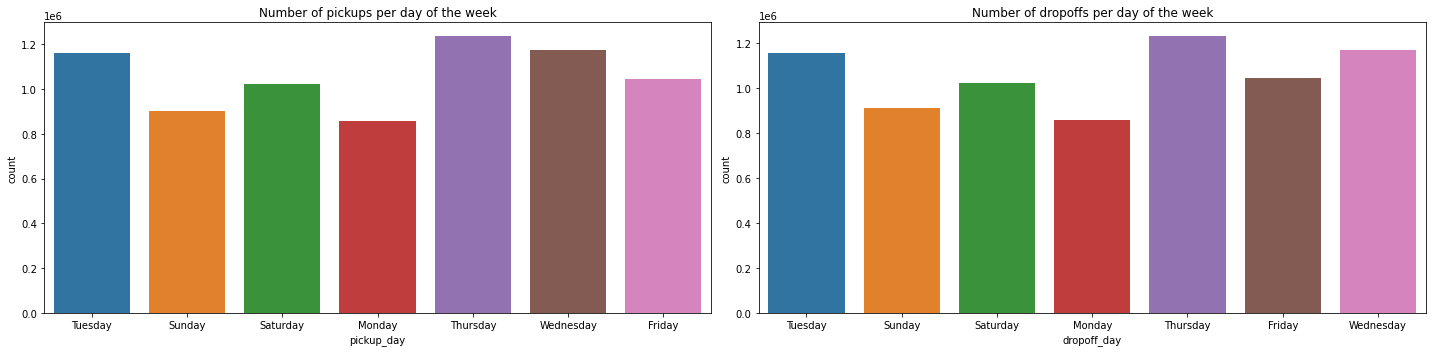

In [206]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='pickup_day',data=data_merged,ax=ax[0])
ax[0].set_title('Number of pickups per day of the week')
sns.countplot(x='dropoff_day',data=data_merged,ax=ax[1])
ax[1].set_title('Number of dropoffs per day of the week')
plt.tight_layout()

**Thursday is the busiest day of the week in both the cases of pickup and drop off.**

### Busiest Hour

In [207]:
def phase_of_the_day (t):
    if t in range (6,12):
        return "Morning"
    elif t in range (12,15):
        return "Afternoon"
    elif t in range (15,21):
        return "Evening"
    else:
        return "Night"
data_merged['pickup_phase_of_the_day']=data_merged['pickup_hour'].apply(phase_of_the_day)
data_merged['dropoff_phase_of_the_day']=data_merged['dropoff_hour'].apply(phase_of_the_day)

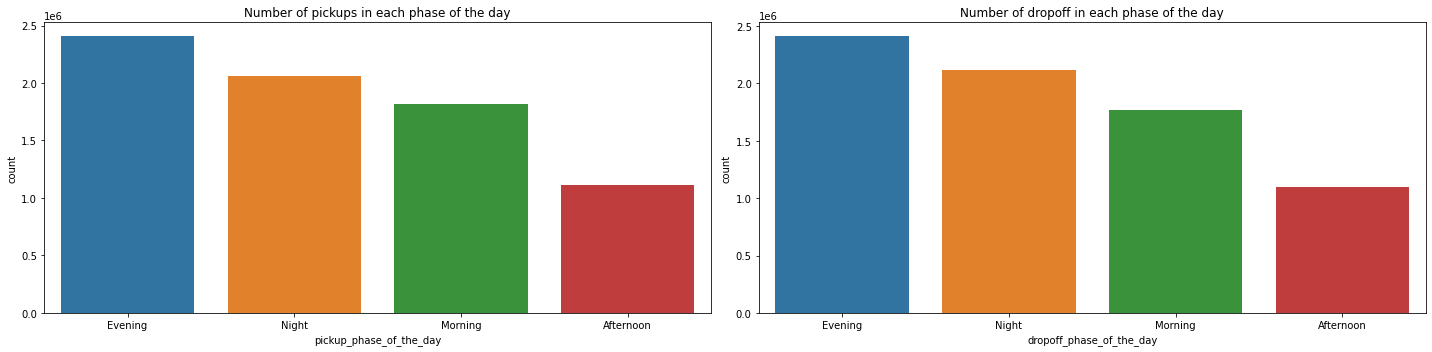

In [208]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='pickup_phase_of_the_day',data=data_merged,ax=ax[0])
ax[0].set_title('Number of pickups in each phase of the day')
sns.countplot(x='dropoff_phase_of_the_day',data=data_merged,ax=ax[1])
ax[1].set_title('Number of dropoff in each phase of the day')
plt.tight_layout()

**Evenings are the busiest time of the day for the taxis (i.e. betweeen 3 to 9 pm)**

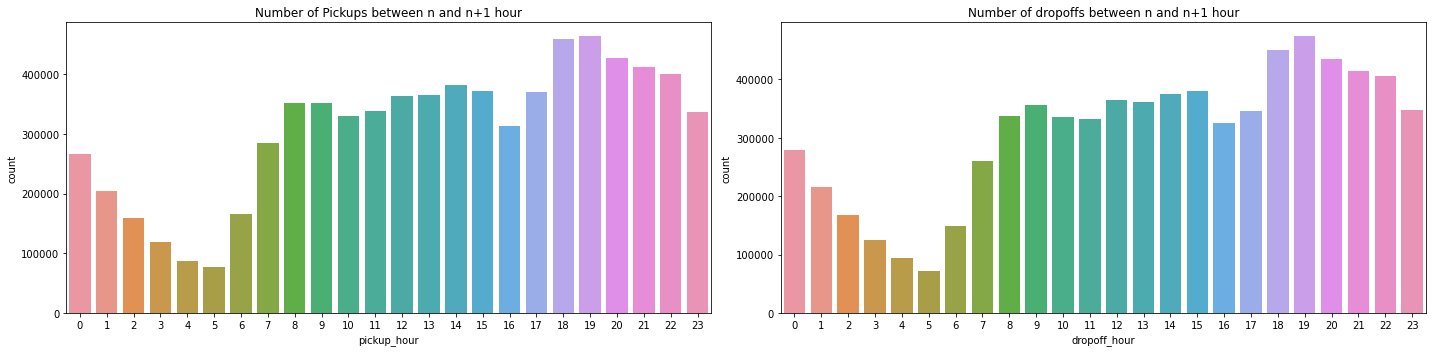

In [209]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='pickup_hour',data=data_merged,ax=ax[0])
ax[0].set_title('Number of Pickups between n and n+1 hour')
sns.countplot(x='dropoff_hour',data=data_merged,ax=ax[1])
ax[1].set_title('Number of dropoffs between n and n+1 hour')
plt.tight_layout()

**More specifically, the busiest time for the drivers is between 6pm to 9pm**

## How are passengers per trip, payment type, fare and tip amounts distributed?¶

### Passengers per trip (Legal)

Text(0.5, 1.0, 'Passenger count Distribution')

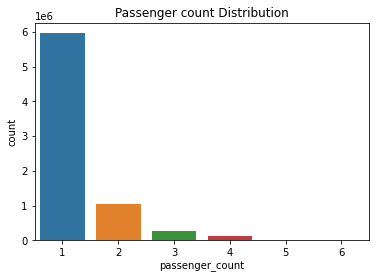

In [210]:
sns.countplot(data=data_merged,x ='passenger_count').set_title('Passenger count Distribution')

**Data for the passengers seems to be right skewed. Overwhelming number of taxi cabs are used by a sole passenger. More cabs are hailed by a single passenger than the total number of cabs hailed by two or more passengers**

### Payment Type Distribution

Card transaction percentaged:  51.836211196415995
Cash transaction percentaged:  47.69403160246233


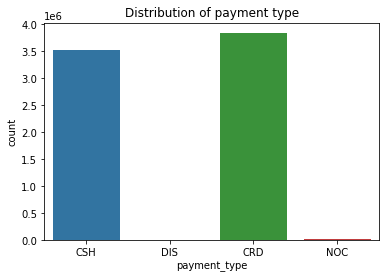

In [211]:
sns.countplot(data=data_merged,x ='payment_type').set_title('Distribution of payment type')
# printing cash and credit percentage
print('Card transaction percentage: ',data_merged[data_merged['payment_type']=='CRD'].shape[0]/data_merged.payment_type.shape[0]*100)
print('Cash transaction percentage: ',data_merged[data_merged['payment_type']=='CSH'].shape[0]/data_merged.payment_type.shape[0]*100)

**Card payment is the most used and cash is the second most used source of payment in taxis. Card transactiona medium accounts for 51.8 percent of the total transactions**

### Fare Distribution

Text(0.5, 1.0, 'Fare Amount Distribution without Top and Bottom 1%')

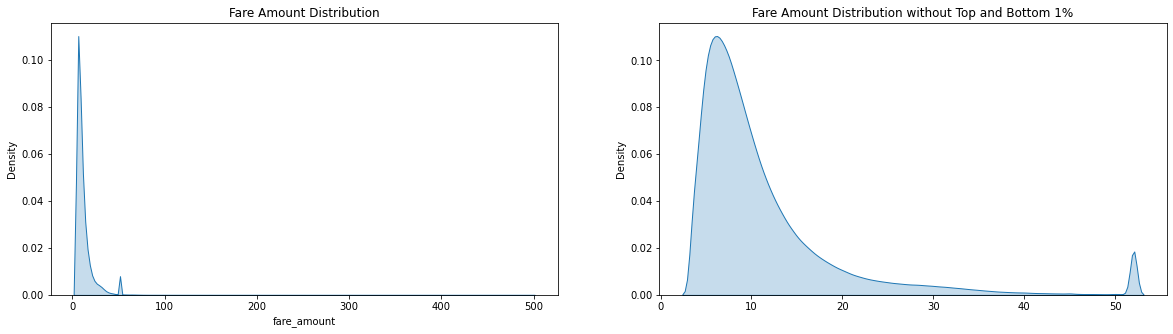

In [330]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.kdeplot(data_merged['fare_amount'],ax = ax[0],fill=True)
ax[0].set_title('Fare Amount Distribution')
sns.kdeplot(winsorize(data_merged['fare_amount'], limits=[0.01, 0.01]),ax = ax[1],fill = True)
ax[1].set_title('Fare Amount Distribution without Top and Bottom 1%')


In [381]:
data_merged.fare_amount.mean()

11.453520112789267

**As can be seen in the above plots, the data for the fare is right skewed. The data has high fare population srounf 10 dollares for fare.** 

### Tip Amount Distribution

Text(0.5, 1.0, 'Tip Amount Distribution without Top and Bottom 1%')

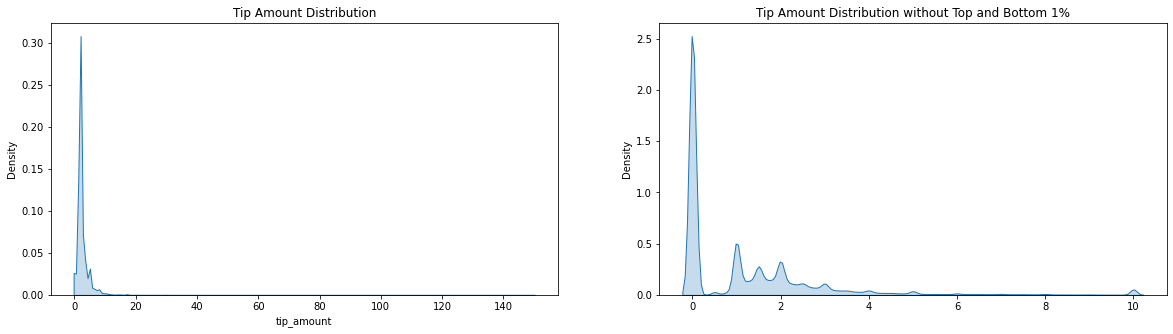

In [213]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.kdeplot(data_merged['tip_amount'],ax = ax[0],fill=True)
ax[0].set_title('Tip Amount Distribution')
sns.kdeplot(winsorize(data_merged['tip_amount'], limits=[0.01, 0.01]),ax = ax[1],fill = True)
ax[1].set_title('Tip Amount Distribution without Top and Bottom 1%')

**As can be seen in the plots above, population is high towards zero**

## How do fares vary by trips?

In [215]:
# Defining trip as the route of the trip
data_merged['trip'] = data_merged.pickup_geocode + ' : ' + data_merged.dropoff_geocode
# Defining trip time in secs
data_merged['trip_time_in_hours'] = 1.0*data_merged['trip_time_in_secs']/3600
# Defining earning per hour
data_merged['earnings_per_hour'] = 1.0*data_merged['total_amount']/data_merged['trip_time_in_hours']

following assumptions are used for sample threshold determination:
- Margin of Error = 5%
- Confidence Interval = 95% which is a Z-Score of 1.96
- Standard Deviation = 0.5 (expecting 50% standard deviation will ensure large enough sample size)
- Required sample size threshold= ((1.96 x 0.5)/0.05)^2 = 384.16 = 385 trips


In [136]:
# Filter down to routes with 385+ trips
data_merged_trip = data_merged.groupby('trip').filter(lambda x: len(x) >= 385)

In [346]:
# Bottom 10 trip routes accrding to earning  per hour 
data_bot_earn_hr = pd.DataFrame(data_merged.groupby(['trip'])['earnings_per_hour'].mean().sort_values(ascending=True).head(10))

In [363]:
data_bot_earn_hr

earnings_per_hour
trip                                            
40.86, -73.93 : 40.74, -73.83           1.353553
40.72, -74.0 : 40.82, -73.61            1.431005
40.65, -73.78 : 40.69, -73.6            1.712655
40.71, -74.02 : 40.67, -74.2            1.712926
40.75, -74.0 : 40.66, -73.79            1.923762
40.65, -73.78 : 40.72, -73.93           1.941399
40.77, -73.98 : 40.7, -73.81            1.976161
40.72, -73.98 : 40.84, -73.9            2.040155
40.77, -73.87 : 40.92, -73.84           2.055130
40.73, -73.93 : 40.74, -73.92           2.295918

In [361]:
# Top 10 trip accrding to earning  per hour 
data_top_earn_hr = pd.DataFrame(data_merged.groupby(['trip'])['earnings_per_hour'].mean().sort_values(ascending=False).head(10))

In [362]:
data_top_earn_hr

earnings_per_hour
trip                                            
40.94, -73.75 : 40.94, -73.75      360000.000000
40.9, -73.8 : 40.9, -73.8          225900.000000
40.78, -74.27 : 40.78, -74.27      142269.230769
40.64, -74.0 : 40.64, -74.0         64380.643127
40.75, -73.75 : 40.75, -73.75       63000.000000
40.62, -73.95 : 40.62, -73.95       58759.223220
40.63, -73.71 : 40.63, -73.71       55800.000000
41.12, -73.71 : 41.12, -73.71       50580.000000
40.83, -74.21 : 40.83, -74.21       49488.461538
40.64, -74.77 : 40.64, -74.77       44437.500000

In [373]:
# Top 5 least time taking trips
data_bot_time = pd.DataFrame(data_merged.groupby('trip')['trip_time_in_hours'].mean().sort_values(ascending=True).head(5))

In [374]:
# Top 5 highest time taking trips
data_top_time = pd.DataFrame(data_merged.groupby('trip')['trip_time_in_hours'].mean().sort_values(ascending=False).head(5))

In [377]:
data_bot_time

trip_time_in_hours
trip                                             
40.81, -73.22 : 40.81, -73.22            0.000278
40.88, -73.93 : 40.88, -73.93            0.000278
40.94, -73.75 : 40.94, -73.75            0.000278
40.9, -73.8 : 40.9, -73.8                0.000556
40.74, -73.8 : 40.74, -73.8              0.000556

In [378]:
data_top_time

trip_time_in_hours
trip                                             
40.77, -73.9 : 40.66, -73.79             2.637778
40.61, -73.82 : 40.66, -73.81            2.595833
40.77, -73.78 : 40.76, -73.78            2.548889
40.66, -73.79 : 40.52, -74.45            2.547778
40.7, -73.82 : 40.04, -75.1              2.455833

# Is it possible to characterise taxi drivers based on work hours and how much they make?

In [123]:
data_temp = pd.DataFrame(data_merged.groupby(['hack_license'])['earnings_per_hour'].mean().sort_values(ascending=False))

In [124]:
avg = data_temp.earnings_per_hour.mean()
data_temp['earns_more_than_avg'] = 'No'

In [125]:
for i in range(0,data_temp.shape[0]):
    if data_temp['earnings_per_hour'][i] > int(avg):
        data_temp['earns_more_than_avg'][i] = 'Yes'
    else:
        data_temp['earns_more_than_avg'][i] = 'No'
      

Text(0.5, 1.0, 'Taxi driver distribution - earning per hour ')

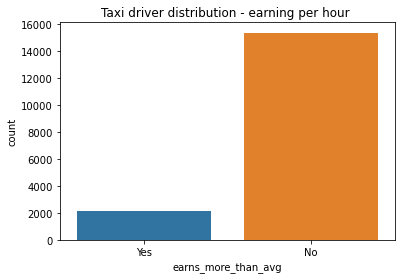

In [126]:
sns.countplot(data_temp['earns_more_than_avg']).set_title('Taxi driver distribution - earning per hour ')

In [127]:
data_temp2 = pd.DataFrame(data_merged.groupby(['hack_license'])['trip_time_in_hours'].mean().sort_values())

In [128]:
avg_time = data_temp2.trip_time_in_hours.mean()
data_temp2['works_more_than_avg'] = 'No'

In [129]:
for i in range(0,data_temp2.shape[0]):
    if data_temp2['trip_time_in_hours'][i] > avg_time:
        data_temp2['works_more_than_avg'][i] = 'Yes'
    else:
        data_temp2['works_more_than_avg'][i] = 'No'
      

Text(0.5, 1.0, 'Taxi driver distribution - Work per hour')

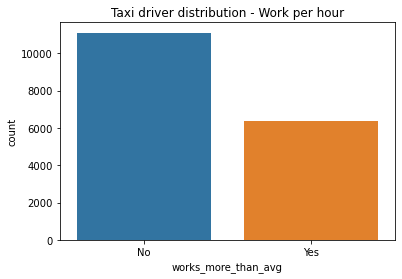

In [130]:
sns.countplot(data_temp2['works_more_than_avg']).set_title('Taxi driver distribution - Work per hour')

In [307]:
data_merged3 = pd.merge(data_temp,data_temp2, on =['hack_license'])
data_merged3['Characteristic'] = 'Efficient'

In [308]:
for i in range(0,data_merged3.shape[0]):
    if (data_merged3['earns_more_than_avg'][i] == 'Yes' and data_merged3['works_more_than_avg'][i] == 'No'):
        data_merged3['Characteristic'][i] = 'Highly Efficient'
    elif (data_merged3['earns_more_than_avg'][i] == 'No' and data_merged3['works_more_than_avg'][i] =='Yes'):
        data_merged3['Characteristic'][i] = 'Less Efficient'

Text(0.5, 1.0, 'taxi driver trip planning characteristic distribution')

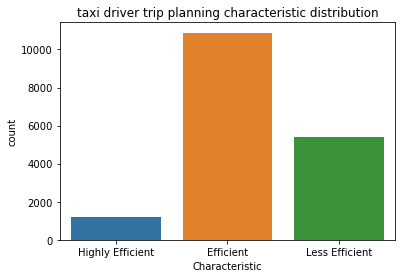

In [309]:
sns.countplot(data_merged3['Characteristic']).set_title('taxi driver trip planning characteristic distribution')

In [310]:
print('percentage of highly efficient drivers: ',data_merged3[data_merged3['Characteristic']=='Highly Efficient'].shape[0]/data_merged3.Characteristic.shape[0]*100)
print('percentage of efficient efficient drivers: ',data_merged3[data_merged3['Characteristic']=='Efficient'].shape[0]/data_merged3.Characteristic.shape[0]*100)
print('percentage of less efficient drivers: ',data_merged3[data_merged3['Characteristic']=='Less Efficient'].shape[0]/data_merged3.Characteristic.shape[0]*100)

percentage of highly efficient drivers:  6.736107136725233
percentage of efficient efficient drivers:  62.26177531047903
percentage of less efficient drivers:  31.002117552795745


# Fare Prediction

## Feature selection

In [216]:
data_merged['avg_speed2'] = data_merged.avg_speed/3600

Text(0.5, 1.0, 'Correlation Plot')

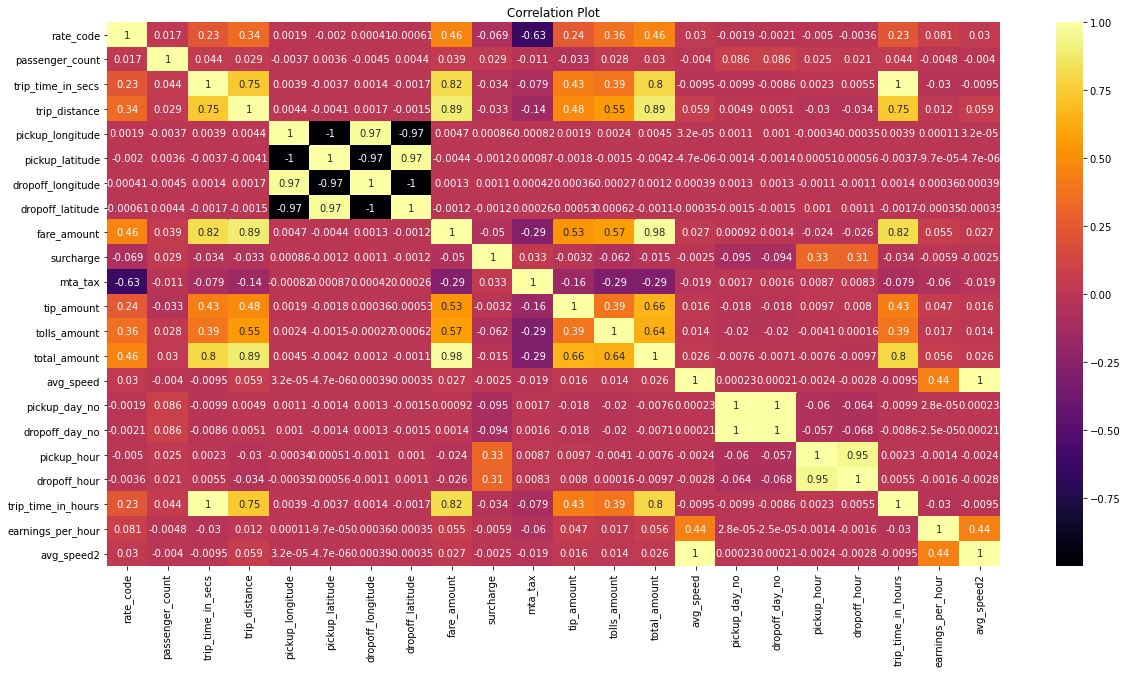

In [217]:
# Correlation Matrix
plt.figure(figsize=(20,10))
sns.heatmap(data_merged.corr(), annot=True, cmap='inferno')
plt.title('Correlation Plot')

Based on the above correlation heatmap, strong correlated features for variable fair_amount (threshold = 0.4) are:
- rate_code
- trip_time_in_secs
- trip_distance

we will only use these for the fare prediction models.

## Modelling

In [218]:
# features
features = ['rate_code','trip_time_in_secs','trip_distance']

In [219]:
# independent variables
X = data_merged[features]
# target variable
Y = data_merged['fare_amount']

In [220]:
columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)

In [221]:
# splitting data into train test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.2, random_state=1)

In [222]:
# linear regression
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [223]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse', oob_score = True, n_jobs = -1,
                           random_state =123, max_features = "auto", min_samples_leaf = 50, max_depth = 5)
rf.fit(X_train,Y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=50, n_jobs=-1,
                      oob_score=True, random_state=123)

In [224]:
# Decision tree
dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
dt.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=10)

In [225]:
# Predictions
lr_test = lr.predict(X_test)
rf_test = rf.predict(X_test)
dt_test = dt.predict(X_test)

# R squared
test_score_lr = r2_score(Y_test, lr_test)
test_score_rf = r2_score(Y_test, rf_test)
test_score_dt = r2_score(Y_test, dt_test)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(lr_test, Y_test))
rmse_rf = np.sqrt(mean_squared_error(lr_test, Y_test))
rmse_dt = np.sqrt(mean_squared_error(dt_test, Y_test))

In [226]:
# Metric Table

# Columns
fare_metric_table = PrettyTable(["Metric", "Linear Regression","Random Forest","Decion Trees"])
# Rows
fare_metric_table.add_row(["R Squared", test_score_lr, test_score_rf, test_score_dt])
fare_metric_table.add_row([" "," "," "," "])
fare_metric_table.add_row(["RMSE ", rmse_lr, rmse_rf, rmse_dt])
print(fare_metric_table)

+-----------+--------------------+--------------------+--------------------+
|   Metric  | Linear Regression  |   Random Forest    |    Decion Trees    |
+-----------+--------------------+--------------------+--------------------+
| R Squared | 0.8831567875119295 | 0.9240826891736218 | 0.9632966526209973 |
|           |                    |                    |                    |
|   RMSE    | 3.1196010482195358 | 3.1196010482195358 | 1.7484376514914046 |
+-----------+--------------------+--------------------+--------------------+


In [227]:
# Cross Validation
sklearn.model_selection.cross_val_score(dt, X, Y, cv=10).mean()

0.9604107910327027

**R squared value signifies the quality of the fit, with 0 being the worst fit to 1 being the best. Decision Tree have the highest value 

/var/folders/b6/1cfrv6894wl0ndlxc6jrhqvw0000gn/T/ipykernel_2070/2269988950.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,1,1)


Text(0.5, 1.0, 'Test VS Prediction')

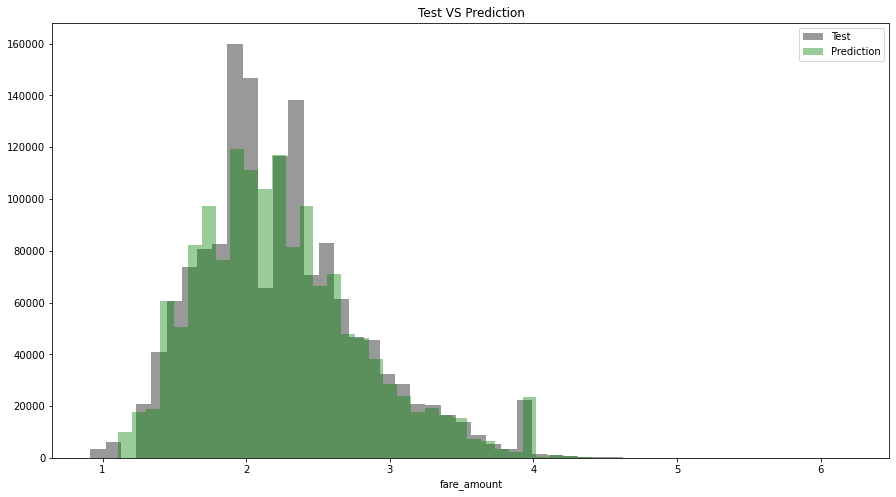

In [228]:
# plot fitted distribution vs test data distribution
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(np.log(Y_test), kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(np.log(dt_test), kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

As can be seen in the plot, fitted values are following a similar distribution. Hence, model is a good fit for the problem

# Tip Prediction

## Feature Selection

In [230]:
# Selecting only rows with payment_type card due to a large amount of missing data in payment_type cash
data_tip = data_merged[data_merged['payment_type']=='CRD']
# independent variables
X = data_tip.drop(data_tip[['tip_amount','pickup_phase_of_the_day','dropoff_phase_of_the_day','pickup_day','dropoff_day','hack_license','medallion','vendor_id','pickup_datetime','dropoff_datetime','total_amount','payment_type','pickup_geocode','dropoff_geocode','trip']],axis = 1)
# Target Variable
Y = data_tip.tip_amount

In [231]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

In [283]:
# selecting pca components according to 95% variance cutoff threshold
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
X_pca = pd.DataFrame(reduced)
X_pca.shape


(3835876, 5)

In [284]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, Y, test_size=0.20, shuffle=True)

## Modelling

In [285]:
# Linear Regression
ls = LinearRegression()
ls.fit(X_train_pca,y_train)

LinearRegression()

In [286]:
# Huber Regressor
hr = HuberRegressor()
hr.fit(X_train_pca,y_train)

HuberRegressor()

In [287]:
# Decision tree
dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
dt.fit(X_train_pca, y_train)

DecisionTreeRegressor(max_depth=10)

In [288]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse', oob_score = True, n_jobs = -1,
                           random_state =123, max_features = "auto", min_samples_leaf = 50, max_depth = 5)
rf.fit(X_train_pca,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=50, n_jobs=-1,
                      oob_score=True, random_state=123)

In [289]:
# Prediction
lr_test = ls.predict(X_test_pca)
hr_test = hr.predict(X_test_pca)
rf_test = rf.predict(X_test_pca)
dt_test = dt.predict(X_test_pca)

# R squared
test_score_lr = r2_score(y_test, lr_test)
test_score_hr = r2_score(y_test, hr_test)
test_score_rf = r2_score(y_test, rf_test)
test_score_dt = r2_score(y_test, dt_test)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(lr_test, y_test))
rmse_hr = np.sqrt(mean_squared_error(hr_test, y_test))
rmse_rf = np.sqrt(mean_squared_error(rf_test, y_test))
rmse_dt = np.sqrt(mean_squared_error(dt_test, y_test))

In [290]:
# Metric Table

# Columns
fare_metric_table = PrettyTable(["Metric", "Linear Regression","Huber Regressor","Random Forest","Decion Trees"])
# Rows
fare_metric_table.add_row(["R Squared", test_score_lr,test_score_hr, test_score_rf, test_score_dt])
fare_metric_table.add_row([" "," "," "," "," "])
fare_metric_table.add_row(["RMSE ", rmse_lr, rmse_hr, rmse_rf, rmse_dt])
print(fare_metric_table)

+-----------+--------------------+--------------------+--------------------+--------------------+
|   Metric  | Linear Regression  |  Huber Regressor   |   Random Forest    |    Decion Trees    |
+-----------+--------------------+--------------------+--------------------+--------------------+
| R Squared | 0.5038654222021502 | 0.4612077153558397 | 0.5805264434405961 | 0.5912452417309757 |
|           |                    |                    |                    |                    |
|   RMSE    | 1.5368615288144065 | 1.601569078936828  | 1.4131468197773354 | 1.3949749277328876 |
+-----------+--------------------+--------------------+--------------------+--------------------+


In [255]:
# Cross Validation
sklearn.model_selection.cross_val_score(dt, X, Y, cv=5).mean()

0.6480968133631351

/var/folders/b6/1cfrv6894wl0ndlxc6jrhqvw0000gn/T/ipykernel_2070/1834083832.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,1,1)


Text(0.5, 1.0, 'Test VS Prediction')

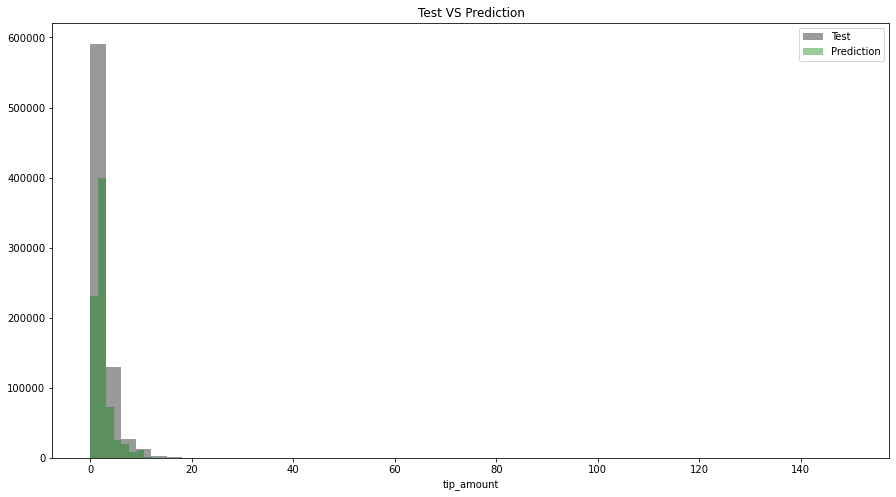

In [293]:
# Plot Fitted vs test data distribution
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot((y_test), kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot((dt_test), kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

As can be seen by the plot, the fitted values seems underfitted. A reason for this problem could lack of data.

# If you were a taxi owner, how would you maximize your earnings in a day?

Some of the ways to maximize the earning
- Take trips that provides high earning per hour
- Servicing and repairing cars on off days (Sunday, Monday)
- Avoid trips with low average speed (traffic) during busy hours
- Removing working our restriction, i.e., hiring more drivers such that taxi is running 24/7
- Station near busy locations


# If you run a taxi company with 10 taxis, how would you maximize your earnings?

Some of the measures to maximize the earning:
- Hire enough drivers to ensure all taxi are running 24/7
- Servicing and repairing of cars on off days (Sunday, Monday)
- Advice drivers to take trips that provides high earning per hour
- Avoid routes with low average speed (traffic) during busy hours
- Advice drivers to station near busy locations
- Providing a choice to drivers to work on high variance trips after making the average wage for drivers in NYC 2013(245 $) 




# What possible issues in the data might impact your approach?

There is very less recorded data for cash tips and this inadequacy of data can lead to underfitted models


# What are the potential drawbacks to using the selected model? What other models might be useful?

Decision trees are very fragile towards noise. Even a small noise in the data for prediction can hinder its fitting capabilities
